<a href="https://colab.research.google.com/github/amc9834/AnaliticaDatos/blob/master/Fifa_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FIFA19 con Redes Neuronales
Aplicando API funcional y redes multimodales


In [1]:
#Obtener archivos desde Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#
file_id1 = '1hfWCeoNPVhD81S3w_KQFPhc-Qw7Uk8bU' #Base de datos
csv_path = drive.CreateFile({'id': file_id1})
csv_path.GetContentFile('data.csv') 

file_id2 = '1RgsmMTYD5hnxaabWb369bzS2fV3ER5bC' #Funciones
csv_path1 = drive.CreateFile({'id': file_id2})
csv_path1.GetContentFile('funciones_fifa_v2.py') 

file_id3 = '1kQ98dUD-e2Z2L-KH2T6F-yyeBUfTjSh_' #imagenes
csv_path1 = drive.CreateFile({'id': file_id3})
csv_path1.GetContentFile('images_.zip') 





ApiRequestError: ignored

In [0]:
#Paso1: lectura e importación
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from funciones_fifa_v2 import dummy_fifa, pre_exploratorio, save_fig, prices, code_euro
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline


Xdata = pd.read_csv('data.csv')

col_drop = ['Name','ID','Photo','Flag','Club Logo','Loaned From']
Xdata.drop(columns = col_drop, inplace = True)

col_sal = "Value"
y = Xdata[col_sal]
Xdata.drop(columns=col_sal,inplace=True)


In [0]:
#Paso 2: Definición Funciones para Preproceso y Obtencion de Rango para Clasificación, bueno, malo y regular

def prepros(Xdata):

  cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
          'Work Rate','Real Face']
  items = [] 
  for i in cat:
      items += [list(Xdata[i].value_counts().index)]
  cat_usr = dict(zip(cat, items))

  Xdata_pre = dummy_fifa(cat_usr = cat_usr).fit_transform(Xdata)

  return Xdata_pre


def prom_stats(Xdata):
  y_class = []
  idx = np.array(Xdata['Unnamed: 0'])
  for a in range(Xdata.shape[0]):
          if(Xdata.ix[idx[a]]['Overall'] < 58):
              y_class.append(0)
          elif(58 <= Xdata.ix[idx[a]]['Overall'] <= 70):
              y_class.append(1)
          elif(Xdata.ix[idx[a]]['Overall'] > 70):
              y_class.append(2)
  return np.array(y_class)


In [0]:
#Paso 3: Creación de Carpetas según subgrupos de datos y Obtención de imágenes
import os
os.mkdir("Xtrain")
os.mkdir("Xtest")
os.mkdir("Xval")

import zipfile
with zipfile.ZipFile("images_.zip", 'r') as zip_ref:
   zip_ref.extractall("imag")

In [0]:
#Paso 4: Función para mover imágenes a carpetas y crear set de datos de imagenes
from shutil import copyfile
import cv2
def imags_fold(Xdata,Name):
  idx = np.array(Xdata['Unnamed: 0'])
  img = np.zeros((Xdata.shape[0],48,48,3))
  for i in range(Xdata.shape[0]):
    pth = "imag/images/"
    dest = Name + "/"
    num = str(idx[i])
    copyfile(pth + num + ".png", dest + num + ".png")
    img[i,:,:,:] = (cv2.imread(dest + num + ".png"))
  return img/255.



In [0]:
#Paso 5: Partición de conjustos de entrenamiento y prueba
y = SimpleImputer(strategy="most_frequent").fit_transform(pd.DataFrame(y)).reshape(-1)
y = code_euro(y)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, y, test_size=0.3)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.3)



In [0]:
#Paso 6: Movimientos Imágenes, Preproceso de Datos y Creación de Salida para Clasificación
Xtrain_img = imags_fold(Xtrain,"Xtrain")
Xtest_img = imags_fold(Xtest,"Xtest")
Xval_img = imags_fold(Xval,"Xval")

Xtrain = prepros(Xtrain)
Xval = prepros(Xval)
Xtest = prepros(Xtest)

yclass_train = prom_stats(Xtrain)
yclass_val = prom_stats(Xval)
yclass_test = prom_stats(Xtest)

Xtrain.drop(columns='Unnamed: 0',inplace=True)
Xtest.drop(columns='Unnamed: 0',inplace=True)
Xval.drop(columns='Unnamed: 0',inplace=True)

#Noramlización de datos
Xtrain = StandardScaler().fit_transform(Xtrain)
Xval = StandardScaler().fit_transform(Xval)
Xtest = StandardScaler().fit_transform(Xtest)

In [7]:
print('Images Xtrain: ', Xtrain_img.shape)
print('Images Xtest: ', Xtest_img.shape)
print('Images Xval: ', Xval_img.shape)


Images Xtrain:  (8920, 48, 48, 3)
Images Xtest:  (5463, 48, 48, 3)
Images Xval:  (3824, 48, 48, 3)


## Red Multimodal de Regresion, Clasificación y Red Convolucional

In [0]:
#Paso7: Creación de la Red Convolucional

import tensorflow as tf
import keras
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

in1 = keras.layers.Input(shape = (48,48,3))
con1 = DefaultConv2D(filters=16, kernel_size=7)(in1)
pol1 = keras.layers.MaxPooling2D(pool_size=2)(con1)
con2 = DefaultConv2D(filters=32)(pol1)
pol2 = keras.layers.MaxPooling2D(pool_size=2)(con2)
con4 = DefaultConv2D(filters=64)(pol2)
pol3 = keras.layers.MaxPooling2D(pool_size=2)(con4)
flat_conv = keras.layers.Flatten()(pol3)
dn1 = keras.layers.Dense(units=30, activation='relu')(flat_conv)
do1 = keras.layers.Dropout(0.5)(dn1)

#Creación de la Red para categoricas
in2 = keras.layers.Input(shape=Xtrain.shape[1:])
h1 = keras.layers.Dense(100,activation='tanh')(in2)
h2 = keras.layers.Dense(50,activation='tanh')(h1)

#Concatenación de Capas
concat= keras.layers.Concatenate()([do1,h2])

#Capas de Salida
output_A = keras.layers.Dense(1, name="Salida_Reg")(concat)
output_B = keras.layers.Dense(3,activation='softmax', name="Salida_Class")(concat)

model_2out = keras.Model(inputs=[in1,in2],outputs=[output_A,output_B])

In [42]:
model_2out.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 48, 48, 16)   2368        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 24, 24, 16)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 24, 24, 32)   4640        max_pooling2d_13[0][0]           
____________________________________________________________________________________________

In [0]:
#Paso8: Compilación del modelo
model_2out.compile(loss={"Salida_Reg":'mse', "Salida_Class":'sparse_categorical_crossentropy'},
                   optimizer='rmsprop',
                   metrics={"Salida_Reg":'mae', "Salida_Class":'accuracy'})

In [44]:
#Paso 9: Entrenamiento del Modelo
history = model_2out.fit([Xtrain_img, Xtrain],[ytrain,yclass_train],
                        epochs=30,
                        validation_data=([Xval_img,Xval],[yval,yclass_val]))

Train on 8920 samples, validate on 3824 samples
Epoch 1/30
8920/8920 [==============================] - 39s 4ms/step - loss: 32059186288902.6602 - Salida_Reg_loss: 32059186288902.6602 - Salida_Class_loss: 9.2300 - Salida_Reg_mean_absolute_error: 2486618.1543 - Salida_Class_acc: 0.4174 - val_loss: 34836143537627.5820 - val_Salida_Reg_loss: 34836143537627.5820 - val_Salida_Class_loss: 5.9389 - val_Salida_Reg_mean_absolute_error: 2580468.2019 - val_Salida_Class_acc: 0.6315
Epoch 2/30
8920/8920 [==============================] - 37s 4ms/step - loss: 30741351734598.0273 - Salida_Reg_loss: 30741351734598.0273 - Salida_Class_loss: 9.7255 - Salida_Reg_mean_absolute_error: 2601644.0776 - Salida_Class_acc: 0.3965 - val_loss: 34923058978918.8281 - val_Salida_Reg_loss: 34923058978918.8281 - val_Salida_Class_loss: 5.9389 - val_Salida_Reg_mean_absolute_error: 2461047.2469 - val_Salida_Class_acc: 0.6315
Epoch 3/30
8920/8920 [==============================] - 37s 4ms/step - loss: 30694337848302.5508 -

In [45]:
model_2out.evaluate([Xtest_img, Xtest],[ytest, yclass_test])

5463/5463 [==============================] - 7s 1ms/step


[30296164631265.773,
 30296164631265.773,
 8.390969040235408,
 2331873.8187351273,
 0.47940691925875767]

In [0]:
import pandas as pd
hdf = pd.DataFrame(history.history)
cols = hdf.columns

In [47]:
cols

Index(['val_loss', 'val_Salida_Reg_loss', 'val_Salida_Class_loss',
       'val_Salida_Reg_mean_absolute_error', 'val_Salida_Class_acc', 'loss',
       'Salida_Reg_loss', 'Salida_Class_loss',
       'Salida_Reg_mean_absolute_error', 'Salida_Class_acc'],
      dtype='object')

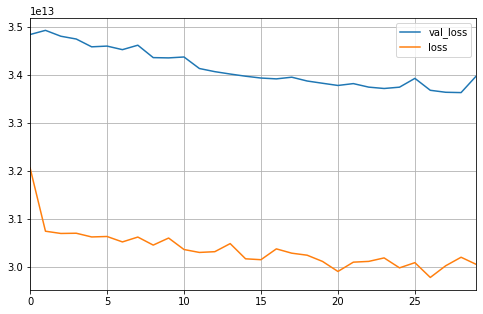

In [48]:
hdf[[cols[0],cols[5]]].plot(figsize=(8, 5))
plt.grid(True)
plt.show()

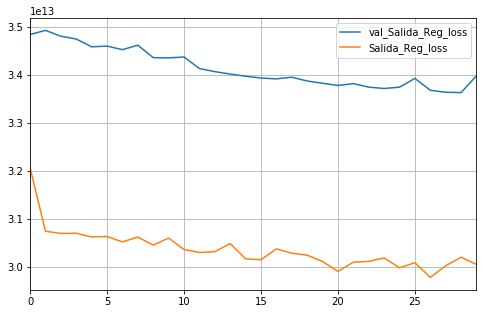

In [49]:
hdf[[cols[1],cols[6]]].plot(figsize=(8, 5))
plt.grid(True)
plt.show()

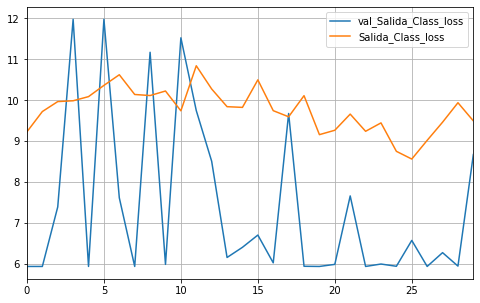

In [50]:
hdf[[cols[2],cols[7]]].plot(figsize=(8, 5))
plt.grid(True)
plt.show()

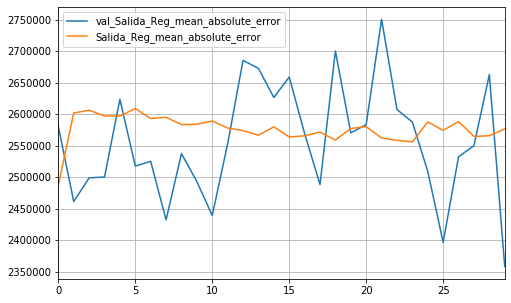

In [51]:
hdf[[cols[3],cols[8]]].plot(figsize=(8, 5))
plt.grid(True)
plt.show()

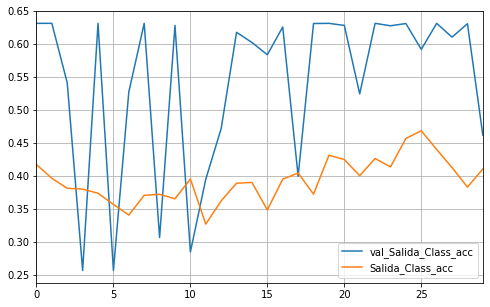

In [52]:
hdf[[cols[4],cols[9]]].plot(figsize=(8, 5))
plt.grid(True)
plt.show()